In [1]:
import random
import os
import numpy as np
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads = 1, inter_op_parallelism_threads = 1)
tf.compat.v1.set_random_seed(42)
sess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import tensorflow
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
import numpy as np

class NNError(Exception):
    pass

def nn_model_structure(layers,
                       neurons,
                       n_cols,
                       weight_initializer = tensorflow.python.keras.initializers.GlorotNormal(),
                       bias_initializer = tensorflow.python.keras.initializers.GlorotNormal(),
                       activation_first = "relu",
                       classification = True
                      ):

    """ Function to define the structure of a neural network.


    Parameters:

    layers (int): Number of layers.
    neurons (list): Number of neurons in each layer.
    n_cols (int): Number of features of the input data (i.e. number of neurons of an input layer).
    weight_initializer (tensorflow.python.ops.init_ops_v2): Initializer of the weights.
    bias_initializer (tensorflow.python.ops.init_ops_v2): Initializer of the biases.
    activation_first (str, or Activation object): Activation function to use in the hidden layers.
    classification (bool): Whether it is a classification (True) or regression (False) problem.


    Returns:

    model (tensorflow.python.keras.engine.sequential.Sequential): Model with the specified structure.

    """

    if len(neurons) != layers:
        raise NNError("Wrong input shape: neurons must be of length of the value of layers.")

    tensorflow.python.keras.backend.clear_session()

    model = Sequential()

    for layer in range(layers):
        # first layer
        if layer == 0:
            model.add(Dense(units = neurons[layer],
                            activation = activation_first,
                            input_shape = (n_cols, ),
                            kernel_initializer = weight_initializer,
                            bias_initializer = bias_initializer
                           )
                     )
        elif layer == layers - 1:
            # output layer
            if classification:
                if neurons[layer] == 2:
                    model.add(Dense(units = neurons[layer],
                                    activation = "sigmoid",
                                    kernel_initializer = weight_initializer,
                                    bias_initializer = bias_initializer
                                   )
                             )
                else:
                    model.add(Dense(units = neurons[layer],
                                    activation = "softmax",
                                    kernel_initializer = weight_initializer,
                                    bias_initializer = bias_initializer
                                   )
                             )
            else:
                model.add(Dense(units = neurons[layer],
                                kernel_initializer = weight_initializer,
                                bias_initializer = bias_initializer
                               )
                         )
        # hidden layers
        else:
            model.add(Dense(units = neurons[layer],
                            activation = activation_first,
                            kernel_initializer = weight_initializer,
                            bias_initializer = bias_initializer
                           )
                     )

    return model

def nn_model_compile(model,
                     optimizer = "adam"
                    ):

    """ Function to compile the neural network. Almost the same as the built-in keras.Model().compile().


    Parameters:

    model (tensorflow.python.keras.engine.sequential.Sequential): Some model.
    optimizer (str or Optimizer object): The optimizer to use.
    show_metrics (list of str): The displayed metrics information.


    Returns:

    model (tensorflow.python.keras.engine.sequential.Sequential): Compiled model.

    """

    output_size = list(np.array(model.trainable_weights[len(model.trainable_weights)-1].shape))[0]

    # regression
    if output_size == 1:
        model.compile(optimizer = optimizer,
                      loss = "mean_squared_error",
                      metrics = ["mse"]
                     )

    # binary classification
    elif output_size == 2:
        model.compile(optimizer = optimizer,
                      loss = "binary_crossentropy",
                      metrics = ["accuracy"]
                     )

    # multiclass classification
    else:
        model.compile(optimizer = optimizer,
                      loss = "categorical_crossentropy",
                      metrics = ["accuracy"]
                     )

    return model

def nn_model_fit(model,
                 X_train,
                 y_train,
                 X_val = None,
                 y_val = None,
                 batch_size = 32,
                 epochs = 10,
                 callbacks = None
                ):

    """ Function to fit the neural network. Almost the same as the built-in keras.Model().fit().


    Parameters:

    model (tensorflow.python.keras.engine.sequential.Sequential): Some model.
    X_train (np.ndarray): Training data.
    y_train (np.ndarray): Training target variable.
    X_val (np.ndarray): Validation data during training.
    y_val (np.ndarray): Validation target data during training.
    batch_size (int): Some batch size.
    epochs (int): Some number of epochs.
    callbacks (list of callbacks objects): Some collection of callbacks.


    Returns:

    model (tensorflow.python.keras.engine.sequential.Sequential): Fitted model.

    """

    model.fit(X_train,
              y_train,
              batch_size = batch_size,
              epochs = epochs,
              callbacks = callbacks,
              validation_data = (X_val, y_val)
             )

    return model

In [4]:
class BatchAccuracy(tensorflow.python.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.acc = []

    def on_batch_end(self, epoch, logs = {}):
        X, y = self.test_data
        self.acc.append(self.model.evaluate(X, y, verbose = 0)[1])

In [5]:
import matplotlib.pyplot as plt

def nn_plot_iter_acc(train_acc_list,
                     test_acc_list,
                     iteration_list,
                     mean_comparison,
                     num_ticks_per_epoch = 2,
                     title = "",
                     savefig = False,
                     file = "../img/accuracy_per_iteration.png",
                     works = False # weg, wenn die Accuracies besser werden
                     ):

    """ Function to plot the evolution of the accuracy of the neural network per iteration.


    Parameters:

    train_acc_list (list): Training accuracies.
    test_acc_list (list): Test accuracies.
    iteration_list (list): Epoch and Batch enumeration.
    mean_comparison (float): Accuracy when always guessing at random.
    title (str): Title of the plot.
    savefig (bool): Whether or not to save the plot.
    file (str): Path and filename if savefig is True.


    """

    epoch_indices = np.array([i for i in range(len(iteration_list)) \
                                  if "Batch: 1." in iteration_list[i]]) + 1
    num_epochs = np.sum(["Batch: 1." in iteration_list[i] for i in range(len(iteration_list))])

    if works: # weg, wenn die Accuracies besser werden
        ymin = 0
        ymax = 1
        yticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
    else:
        ymin = 0.07
        ymax = 0.15
        yticks = np.array([0, 0.1, 0.2])

    xticks = np.linspace(start = 0,
                         stop = len(iteration_list),
                         num = num_epochs * num_ticks_per_epoch + 1)
    xticks[0] = 1

    plt.plot(np.arange(len(train_acc_list)) + 1, train_acc_list, label = "Training")
    plt.plot(np.arange(len(test_acc_list)) + 1, test_acc_list, label = "Testing")
    plt.vlines(x = epoch_indices,
               ymin = ymin, # das muss noch auf 0 gesetzt werden, wenn die Accuracies besser werden
               ymax = ymax, # das muss noch auf 1 gesetzt werden, wenn die Accuracies besser werden
               color = "red",
               linestyle = "dotted",
               label = "Epochs"
               )
    plt.hlines(y = mean_comparison,
               xmin = 1,
               xmax = len(iteration_list),
               color = "black",
               label = "Random guessing")
    plt.legend()
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.xticks(ticks = xticks)
    plt.yticks(ticks = yticks)
    plt.grid()
    if savefig:
        plt.savefig(file)
    plt.show()

In [6]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

def mnist_prep():

    """ Function to prepare the MNIST dataset to use for modeling.


    Parameters:

    Returns:

    X_train_scaled (np.ndarray): Train data X.
    X_test_scaled (np.ndarray): Test data X.
    y_train_onehot (pd.DataFrame): Train data y.
    y_val_onehot (pd.DataFrame): Test data y.

    """
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.reshape(-1, 784).astype("float32") / 255.0
    X_test = X_test.reshape(-1, 784).astype("float32") / 255.0
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    y_train_onehot = pd.get_dummies(y_train)
    y_test_onehot = pd.get_dummies(y_test)

    return X_train_scaled, X_test_scaled, y_train_onehot, y_test_onehot

In [7]:
X_train, X_test, y_train, y_test = mnist_prep()

In [8]:
# use samller dataset for increased speed
X_train = X_train[:10000, :]
X_test = X_test[:5000, :]
y_train = y_train[:10000]
y_test = y_test[:5000]

# EnKF

In [9]:
batch_size = 500             # oder len(X_train)
epochs = 10                  # oder 10, 50
particles = 200             # oder irgendeine natürliche Zahl >1
early_stopping = False
early_stopping_diff = 0.001
batch_normal = False # evtl. noch einbauen, obwohl im Paper nicht gemacht (aber Achtung mit den Dimensionen unten!!!)
shuffle = True
randomization = False

In [10]:
layers = 5
neurons = [128, 128, 64, 32, 10]
n_cols = X_train.shape[1]

In [11]:
delta = 0.005
h_0 = 2
epsilon = 0.5

In [12]:
n = len(X_train)
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [13]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_acc_dict = {}
test_acc_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [14]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_acc_dict["model_{}".format(str(i+1))] = []
    test_acc_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [15]:
# mean_model as the model with the mean of the weights of all particle models
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
mean_model = init_model
mean_model.set_weights(mean_weights)

mean_model_train_acc = np.array(mean_model.evaluate(X_train, y_train)[1])
mean_model_test_acc = np.array(mean_model.evaluate(X_test, y_test)[1])

157/157 [==============================] - 0s 523us/step - loss: 2.3040 - accuracy: 0.0924


In [16]:
import time
start_time_all = time.time()

In [17]:
# loop over all epochs
for epoch in range(epochs):
    start_time = time.time()
    print(epoch)
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [X_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]   
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])

            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            jacobian_dict["model_{}".format(str(i+1))] = (-1) * np.multiply(np.array(y_batches[b]), 
                                                                            np.array(1 / (y_pred_dict["model_{}".format(str(i+1))] + delta)))

            # for every particle write the training accuracy of the current iteration in a dictionary
            train_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_train, y_train, verbose = 0)[1])

            # for every particle write the test accuracy of the current iteration in a dictionary
            test_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                      .evaluate(X_test, y_test, verbose = 0)[1])

            # for every particle write the current iteration in a dictionary
            iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
        
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)

        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))

        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)

        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array

        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            if randomization:
                # add randomization/ noise to each particle
                new_weights = []
                # standard deviation for scaled Glorot distribution
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights

    if randomization:
        # randomize particles around their mean
        weights_mean = list(np.mean(list(weights_dict.values()), axis = 0))
        for i in range(particles):
            new_weights = []
            # standard deviation for Glorot distribution
            for s in range(len(shapes)):
                if shapes[s].shape[0] == 2:
                    fan_in = shapes[s][0]
                    fan_out = shapes[s][1]
                if shapes[s].shape[0] == 1:
                    fan_in = shapes[s-1][0]
                    fan_out = shapes[s][0]
                stddev = np.sqrt(2 / (fan_in + fan_out))
                noise = np.random.normal(loc = 0.0,
                                         scale = stddev,
                                         size = tuple(shapes[s]))
                new_weights.append(weights_mean[s] + noise)
            weights_dict["model_{}".format(str(i+1))] = new_weights

    # update the mean_model
    mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
    mean_model.set_weights(mean_weights)
    
    mean_model_train_acc = np.append(mean_model_train_acc, np.array(mean_model.evaluate(X_train, y_train, verbose = 0)[1]))
    mean_model_test_acc = np.append(mean_model_test_acc, np.array(mean_model.evaluate(X_test, y_test, verbose = 0)[1]))

    # early stopping
    if early_stopping:
        if epoch == 0:
            test_acc_old = 0
        else:
            test_acc_new = mean_model_test_acc[epoch]
            if np.absolute(test_acc_new - test_acc_old) <= early_stopping_diff:
                print("STOP: Early Stopping after epoch {} because improvement in test accuracy is only {}."\
                                                                     .format(epoch+1, test_acc_new - test_acc_old))
                break
            test_acc_old = test_acc_new
    end_time = time.time()
    print("Calculation time of epoch: {} seconds.".format(end_time - start_time))

0
Calculation time of epoch: 888.2369956970215 seconds.
1
Calculation time of epoch: 868.4218168258667 seconds.
2
Calculation time of epoch: 867.1003649234772 seconds.
3
Calculation time of epoch: 867.6213865280151 seconds.
4
Calculation time of epoch: 868.9772629737854 seconds.
5
Calculation time of epoch: 868.0329875946045 seconds.
6
Calculation time of epoch: 867.3307068347931 seconds.
7
Calculation time of epoch: 867.8860247135162 seconds.
8
Calculation time of epoch: 866.6562218666077 seconds.
9
Calculation time of epoch: 868.5867834091187 seconds.


In [18]:
end_time_all = time.time()
print("Calculation time: {}".format(end_time_all - start_time_all))

Calculation time: 8698.901895999908


In [19]:
y_pred_dict["model_1"]

array([[0.09282605, 0.094391  , 0.09963477, ..., 0.10097472, 0.10373019,
        0.09145518],
       [0.09492494, 0.08930251, 0.10572302, ..., 0.10262692, 0.10114681,
        0.0886654 ],
       [0.10123461, 0.08553242, 0.1069833 , ..., 0.10001102, 0.10660034,
        0.09176782],
       ...,
       [0.0940498 , 0.08778329, 0.10731389, ..., 0.10057589, 0.10185386,
        0.09548674],
       [0.09732813, 0.08581707, 0.1081446 , ..., 0.09851107, 0.09695667,
        0.09612878],
       [0.10411749, 0.08497739, 0.10291172, ..., 0.09591312, 0.10794586,
        0.09190004]], dtype=float32)

In [20]:
jacobian_dict["model_1"]

array([[ -0.       , -10.061273 ,  -0.       , ...,  -0.       ,
         -0.       ,  -0.       ],
       [-10.007511 ,  -0.       ,  -0.       , ...,  -0.       ,
         -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       , ...,  -0.       ,
         -8.9605465,  -0.       ],
       ...,
       [-10.095931 ,  -0.       ,  -0.       , ...,  -0.       ,
         -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -8.838247 , ...,  -0.       ,
         -0.       ,  -0.       ],
       [ -0.       ,  -0.       ,  -0.       , ...,  -0.       ,
         -8.8538   ,  -0.       ]], dtype=float32)

In [21]:
print(mean_model_train_acc)
print(mean_model_test_acc)

[0.1014 0.1014 0.1014 0.1014 0.1014 0.1014 0.1014 0.1014 0.1014 0.1014
 0.1014]
[0.0924 0.0924 0.0924 0.0924 0.0924 0.0924 0.0924 0.0924 0.0924 0.0924
 0.0924]


In [22]:
train_acc_dict

{'model_1': [0.11569999903440475,
  0.10930000245571136,
  0.10289999842643738,
  0.09619999676942825,
  0.08290000259876251,
  0.09239999949932098,
  0.06870000064373016,
  0.06350000202655792,
  0.06469999998807907,
  0.07530000060796738,
  0.08550000190734863,
  0.093299999833107,
  0.07169999927282333,
  0.07169999927282333,
  0.07490000128746033,
  0.07270000129938126,
  0.06260000169277191,
  0.062300000339746475,
  0.07699999958276749,
  0.07609999924898148,
  0.05649999901652336,
  0.053199999034404755,
  0.06019999831914902,
  0.0738999992609024,
  0.08860000222921371,
  0.062199998646974564,
  0.061799999326467514,
  0.08959999680519104,
  0.06710000336170197,
  0.09380000084638596,
  0.08240000158548355,
  0.0771000012755394,
  0.08500000089406967,
  0.07919999957084656,
  0.09440000355243683,
  0.0851999968290329,
  0.09679999947547913,
  0.10019999742507935,
  0.10130000114440918,
  0.08730000257492065,
  0.08229999989271164,
  0.08259999752044678,
  0.09780000150203705,
 

In [23]:
test_acc_dict

{'model_1': [0.10840000212192535,
  0.1136000007390976,
  0.10859999805688858,
  0.10199999809265137,
  0.09399999678134918,
  0.09480000287294388,
  0.07100000232458115,
  0.06400000303983688,
  0.06279999762773514,
  0.08079999685287476,
  0.09080000221729279,
  0.10180000215768814,
  0.08340000361204147,
  0.07859999686479568,
  0.07840000092983246,
  0.07639999687671661,
  0.0674000009894371,
  0.06360000371932983,
  0.05959999933838844,
  0.05420000106096268,
  0.055799998342990875,
  0.05180000141263008,
  0.06199999898672104,
  0.05380000174045563,
  0.0689999982714653,
  0.0560000017285347,
  0.062199998646974564,
  0.05860000103712082,
  0.06159999966621399,
  0.07280000299215317,
  0.08299999684095383,
  0.07779999822378159,
  0.07779999822378159,
  0.07620000094175339,
  0.08320000022649765,
  0.08020000159740448,
  0.08980000019073486,
  0.09279999881982803,
  0.08980000019073486,
  0.09040000289678574,
  0.08020000159740448,
  0.08139999955892563,
  0.08760000020265579,
  

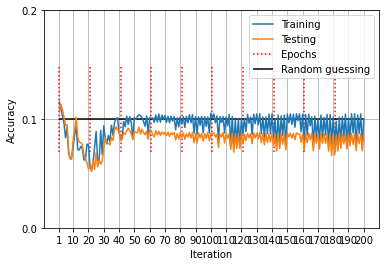

In [24]:
nn_plot_iter_acc(train_acc_dict["model_1"],
                 test_acc_dict["model_1"],
                 iteration_dict["model_1"],
                 mean_comparison = 0.1)

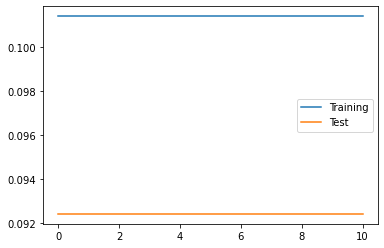

In [25]:
plt.plot(range(epochs+1), mean_model_train_acc, label="Training")
plt.plot(range(epochs+1), mean_model_test_acc, label="Test")
plt.legend()
plt.show()